In [1]:
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def create_usgs_url(site_no, begin_date, end_date):
    return (f'https://waterdata.usgs.gov/nwis/dv?'
        f'cb_00060=on&format=rdb&referred_module=sw&'
        f'site_no={site_no}&'
        f'begin_date={begin_date}&'
        f'end_date={end_date}')

def open_usgs_data(site, begin_date, end_date):
    url = create_usgs_url((site), begin_date, end_date)
    response = urllib.request.urlopen(url)
    df = pd.read_table(
        response, comment='#', skipfooter=1, sep='\s+',
        names=['agency', 'site', 'date', 'streamflow', 'quality_flag'],
        index_col=2, parse_dates=True).iloc[2:]
    df['streamflow'] = df['streamflow'].astype(np.float64)
    df.index = pd.DatetimeIndex(df.index)
    return df

def open_daymet_data(lat, lon, begin_date, end_date):
    args = {'lat':  lat, 'lon': lon, 'format': 'csv',
            'start': begin_date, 'end': end_date}
    query = urllib.parse.urlencode(args)
    url = f"https://daymet.ornl.gov/single-pixel/api/data?{query}"
    response = urllib.request.urlopen(url)
    df = pd.read_csv(response, header=6)
    datestring = (df['year'].astype(str) + df['yday'].astype(str))
    dates = pd.to_datetime(datestring, format='%Y%j')
    df.index = pd.DatetimeIndex(dates)
    return df

In [31]:
site = '09506000'
begin_date = '1988-10-01'
end_date = '2024-10-14'

lat = 34.4483605
lon = -111.7898705
daymet_df = open_daymet_data(lat, lon, begin_date, end_date)
verde_df = open_usgs_data(site, begin_date, end_date)
daymet_df = daymet_df.reindex(verde_df.index)
daymet_df['streamflow'] = verde_df['streamflow']
df = daymet_df
df['date'] = df.index
df['week_of_year'] = df.index.isocalendar().week

# Resample to weekly data
df_weekly = df.resample('W').mean()

/var/folders/7c/k9ztpxkn35s1mbm2kjthjwz80000gn/T/ipykernel_80771/785330650.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_table(
/var/folders/7c/k9ztpxkn35s1mbm2kjthjwz80000gn/T/ipykernel_80771/785330650.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_table(


Text(0.5, 1.0, 'Streamflow at Verde River near Camp Verde, AZ')

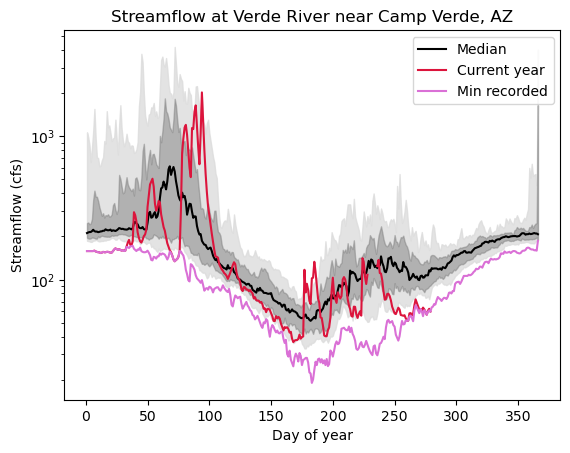

In [62]:
# Compute some statistics
df_doy = df.groupby(df.index.dayofyear).mean()
df_doy_q10 = df.groupby(df.index.dayofyear).quantile(0.10)
df_doy_q90 = df.groupby(df.index.dayofyear).quantile(0.90)
df_doy_q25 = df.groupby(df.index.dayofyear).quantile(0.25)
df_doy_q75 = df.groupby(df.index.dayofyear).quantile(0.75)
df_doy_q50 = df.groupby(df.index.dayofyear).quantile(0.50)
df_doy_min = df.groupby(df.index.dayofyear).min()
df_current_year = df.loc['01-01-2024':'10-14-2024']

# shade between 10th and 90th quantiles, and 25th and 75th quantiles
plt.fill_between(df_doy_q10.index, df_doy_q10['streamflow'], df_doy_q90['streamflow'], color='gainsboro', alpha=0.8)
plt.fill_between(df_doy_q25.index, df_doy_q25['streamflow'], df_doy_q75['streamflow'], color='gray', alpha=0.5)

# Plot the median
plt.plot(df_doy_q50.index, df_doy_q50['streamflow'], color='black', label='Median')
# Plot the current year
plt.plot(df_current_year.index.dayofyear, df_current_year['streamflow'], color='crimson', label='Current year')
plt.plot(df_doy_min.index, df_doy_min['streamflow'], color='orchid', label='Min recorded')
plt.xlabel('Day of year')
plt.ylabel('Streamflow (cfs)')
plt.legend()

plt.semilogy()
plt.title('Streamflow at Verde River near Camp Verde, AZ')

60.21666666666667

In [55]:
quantiles = np.arange(0.00, 1, 0.05)
woy_index = df.loc['10-10-2023'].week_of_year
fc_1_index = woy_index + 1
fc_2_index = woy_index + 2

current_flow_quantiles = []
fc_1_flow_quantiles = []
fc_2_flow_quantiles = []
for q in quantiles:
    df_woy = df.groupby('week_of_year').quantile(q)
    current_flow_quantiles.append(df_woy.loc[woy_index]['streamflow'])
    fc_1_flow_quantiles.append(df_woy.loc[fc_1_index]['streamflow'])
    fc_2_flow_quantiles.append(df_woy.loc[fc_2_index]['streamflow'])

quantile_df = pd.DataFrame({
    'Week starting Oct 7': current_flow_quantiles,
    'Week starting Oct 14': fc_1_flow_quantiles,
    'Week starting Oct 21': fc_2_flow_quantiles
})
quantile_df.index = quantiles

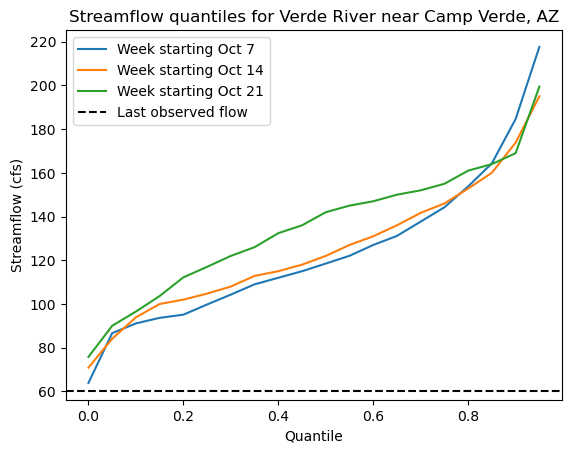

In [56]:
last_q = df_weekly.iloc[-1]['streamflow']
quantile_df.plot()
plt.axhline(last_q, color='black', linestyle='--', label='Last observed flow')
plt.title('Streamflow quantiles for Verde River near Camp Verde, AZ')
plt.xlabel('Quantile')
plt.ylabel('Streamflow (cfs)')
plt.legend()

In [57]:
quantile_df.loc[0]

Week starting Oct 7     63.9
Week starting Oct 14    70.9
Week starting Oct 21    75.8
Name: 0.0, dtype: float64

# Forecast & Report
I am predicting streamflow values of:
- October 14-21, 2024: 70 CFS
- October 21-28, 2024: 75 CFS

I am predicting these values based on using the historic data, and doing a quantile analysis. I chose to do a quantile analysis over using a purely mean-based climatology because of my first figure. Before making a forecast I first wanted to see where the current flows were in the context of the history that I could pull. Originally I looked at the current flows as compared to the mean climatology and realized that it was much lower, which made me look into the distribution of flows across an annual cycle. This is what is shown in figure 1, where you can see the median flow along with the interquartile range and 10/90th percentiles. We can see that the flows are currently in the lower 10th percentile, which is why I chose to use a quantile analysis.

So, to do my actual forecast I chose to calculate the weekly average flow for the periods of Oct 7-14, Oct 14-21, and Oct 21-28 for a variety of quantiles. This is shown in figure 2, where I additionally plot the most current observations as a black dashed line. Flows are currently the lowest ever recorded for this period so I just chose the minimum quantile as a forecast. I would say that I am not very confident in this forecast, as the flows are so low that they are outside of the range of the historical data that I have. However, I think that the forecast is reasonable given the current conditions and the fact that the forecast is for the next week, which is a relatively short time period. This forecast is based on a very short record, and I would not grant very much statistical significance to it as a result.